# High School Timetabling: Database Integration

This notebook extends the basic timetabling model by integrating **SQLAlchemy ORM** for data management. Instead of using `from_data()` with Python lists, we use `from_model(session)` to let LumiX query the database directly.

## What's New

- **SQLAlchemy ORM Models**: Define entities as database tables
- **`from_model(session)`**: LumiX queries the database directly
- **Solution Persistence**: Save optimization results back to the database
- **Type Safety**: IDE autocomplete for model attributes

## Mathematical Formulation

Same as the basic model:

**Decision Variables:**
$$x_{l,t,r} \in \{0, 1\} \quad \text{lecture } l \text{ assigned to timeslot } t \text{ in room } r$$

**Subject to:**
- Each lecture assigned exactly once
- No room conflicts
- No teacher conflicts
- No class conflicts
- Classroom capacity constraints

## 1. Setup and Imports

In [1]:
# Standard library
from typing import Tuple, Dict

# Database
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, Session

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable
from lumix.indexing import LXIndexDimension

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# SQLAlchemy base
Base = declarative_base()

## 2. Define ORM Models

We define SQLAlchemy models for all timetabling entities. These replace the dataclasses from the previous notebook.

In [2]:
class Teacher(Base):
    """Teacher ORM model."""
    __tablename__ = 'teachers'
    
    id = Column(Integer, primary_key=True)
    name = Column(String(100), nullable=False)


class Classroom(Base):
    """Classroom ORM model."""
    __tablename__ = 'classrooms'
    
    id = Column(Integer, primary_key=True)
    name = Column(String(50), nullable=False)
    capacity = Column(Integer, nullable=False)


class SchoolClass(Base):
    """School class (group of students) ORM model."""
    __tablename__ = 'school_classes'
    
    id = Column(Integer, primary_key=True)
    name = Column(String(20), nullable=False)
    size = Column(Integer, nullable=False)


class Subject(Base):
    """Subject ORM model."""
    __tablename__ = 'subjects'
    
    id = Column(Integer, primary_key=True)
    name = Column(String(50), nullable=False)


class TimeSlot(Base):
    """Time slot ORM model."""
    __tablename__ = 'timeslots'
    
    id = Column(Integer, primary_key=True)
    day_of_week = Column(Integer, nullable=False)  # 0=Mon, 4=Fri
    period = Column(Integer, nullable=False)       # 1-6
    day_name = Column(String(20), nullable=False)


class Lecture(Base):
    """Lecture ORM model."""
    __tablename__ = 'lectures'
    
    id = Column(Integer, primary_key=True)
    subject_id = Column(Integer, ForeignKey('subjects.id'), nullable=False)
    teacher_id = Column(Integer, ForeignKey('teachers.id'), nullable=False)
    class_id = Column(Integer, ForeignKey('school_classes.id'), nullable=False)


class ScheduleAssignment(Base):
    """Store optimization results."""
    __tablename__ = 'schedule_assignments'
    
    id = Column(Integer, primary_key=True, autoincrement=True)
    lecture_id = Column(Integer, ForeignKey('lectures.id'), nullable=False)
    timeslot_id = Column(Integer, ForeignKey('timeslots.id'), nullable=False)
    classroom_id = Column(Integer, ForeignKey('classrooms.id'), nullable=False)


print("ORM models defined:")
print("  - Teacher, Classroom, SchoolClass, Subject, TimeSlot, Lecture")
print("  - ScheduleAssignment (for storing results)")

ORM models defined:
  - Teacher, Classroom, SchoolClass, Subject, TimeSlot, Lecture
  - ScheduleAssignment (for storing results)


## 3. Create In-Memory Database

We use an in-memory SQLite database for this notebook. In production, you'd connect to a persistent database.

In [3]:
# Create in-memory SQLite database
engine = create_engine('sqlite:///:memory:', echo=False)
Base.metadata.create_all(engine)

# Create session
SessionLocal = sessionmaker(bind=engine)
session = SessionLocal()

print("In-memory SQLite database created")
print(f"Tables: {list(Base.metadata.tables.keys())}")

In-memory SQLite database created
Tables: ['teachers', 'classrooms', 'school_classes', 'subjects', 'timeslots', 'lectures', 'schedule_assignments']


## 4. Populate the Database

In [4]:
# Teachers
teachers_data = [
    Teacher(id=1, name="Dr. Smith"),
    Teacher(id=2, name="Prof. Johnson"),
    Teacher(id=3, name="Ms. Williams"),
    Teacher(id=4, name="Mr. Brown"),
    Teacher(id=5, name="Dr. Davis"),
]
session.add_all(teachers_data)

# Classrooms
classrooms_data = [
    Classroom(id=1, name="Room 101", capacity=30),
    Classroom(id=2, name="Room 102", capacity=30),
    Classroom(id=3, name="Room 201", capacity=25),
    Classroom(id=4, name="Lab A", capacity=20),
]
session.add_all(classrooms_data)

# School Classes
classes_data = [
    SchoolClass(id=1, name="9A", size=25),
    SchoolClass(id=2, name="9B", size=28),
    SchoolClass(id=3, name="10A", size=24),
    SchoolClass(id=4, name="10B", size=26),
]
session.add_all(classes_data)

# Subjects
subjects_data = [
    Subject(id=1, name="Math"),
    Subject(id=2, name="English"),
    Subject(id=3, name="Physics"),
    Subject(id=4, name="Chemistry"),
    Subject(id=5, name="History"),
]
session.add_all(subjects_data)

# Timeslots (5 days x 6 periods)
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
slot_id = 1
for day in range(5):
    for period in range(1, 7):
        session.add(TimeSlot(id=slot_id, day_of_week=day, period=period, day_name=DAY_NAMES[day]))
        slot_id += 1

# Lectures
lectures_data = [
    # Math (Dr. Smith)
    Lecture(id=1, subject_id=1, teacher_id=1, class_id=1),
    Lecture(id=2, subject_id=1, teacher_id=1, class_id=1),
    Lecture(id=3, subject_id=1, teacher_id=1, class_id=2),
    Lecture(id=4, subject_id=1, teacher_id=1, class_id=2),
    # English (Prof. Johnson)
    Lecture(id=5, subject_id=2, teacher_id=2, class_id=1),
    Lecture(id=6, subject_id=2, teacher_id=2, class_id=2),
    Lecture(id=7, subject_id=2, teacher_id=2, class_id=3),
    # Physics (Ms. Williams)
    Lecture(id=8, subject_id=3, teacher_id=3, class_id=3),
    Lecture(id=9, subject_id=3, teacher_id=3, class_id=3),
    Lecture(id=10, subject_id=3, teacher_id=3, class_id=4),
    Lecture(id=11, subject_id=3, teacher_id=3, class_id=4),
    # Chemistry (Mr. Brown)
    Lecture(id=12, subject_id=4, teacher_id=4, class_id=3),
    Lecture(id=13, subject_id=4, teacher_id=4, class_id=4),
    # History (Dr. Davis)
    Lecture(id=14, subject_id=5, teacher_id=5, class_id=1),
    Lecture(id=15, subject_id=5, teacher_id=5, class_id=2),
    Lecture(id=16, subject_id=5, teacher_id=5, class_id=3),
    Lecture(id=17, subject_id=5, teacher_id=5, class_id=4),
    # Additional Math
    Lecture(id=18, subject_id=1, teacher_id=1, class_id=3),
    Lecture(id=19, subject_id=1, teacher_id=1, class_id=4),
    # Additional English
    Lecture(id=20, subject_id=2, teacher_id=2, class_id=4),
]
session.add_all(lectures_data)

session.commit()

print("Database populated:")
print(f"  Teachers: {session.query(Teacher).count()}")
print(f"  Classrooms: {session.query(Classroom).count()}")
print(f"  Classes: {session.query(SchoolClass).count()}")
print(f"  Subjects: {session.query(Subject).count()}")
print(f"  Timeslots: {session.query(TimeSlot).count()}")
print(f"  Lectures: {session.query(Lecture).count()}")

Database populated:
  Teachers: 5
  Classrooms: 4
  Classes: 4
  Subjects: 5
  Timeslots: 30
  Lectures: 20


## 5. Query and Visualize Data from Database

In [5]:
# Query teachers from database
teachers_df = pd.read_sql(session.query(Teacher).statement, session.bind)
print("Teachers (from database):")
display(teachers_df)

# Query classrooms
classrooms_df = pd.read_sql(session.query(Classroom).statement, session.bind)
print("\nClassrooms (from database):")
display(classrooms_df)

# Query school classes
classes_df = pd.read_sql(session.query(SchoolClass).statement, session.bind)
print("\nSchool Classes (from database):")
display(classes_df)

Teachers (from database):


,id,name
0,1,Dr. Smith
1,2,Prof. Johnson
2,3,Ms. Williams
3,4,Mr. Brown
4,5,Dr. Davis



Classrooms (from database):


,id,name,capacity
0,1,Room 101,30
1,2,Room 102,30
2,3,Room 201,25
3,4,Lab A,20



School Classes (from database):


,id,name,size
0,1,9A,25
1,2,9B,28
2,3,10A,24
3,4,10B,26


## 6. Build the Model with `from_model()`

The key difference from the basic notebook: we use `from_model(session)` instead of `from_data(list)`.

```python
# Before (basic notebook)
LXIndexDimension(Lecture, lambda l: l.id).from_data(LECTURES)

# After (with ORM)
LXIndexDimension(Lecture, lambda l: l.id).from_model(session)
```

In [6]:
def create_cached_fits_checker(session: Session) -> callable:
    """
    Create a cached function to check if class fits in classroom.
    
    Caching avoids repeated database queries for the same class/room pair.
    """
    # Pre-load all data into memory for fast lookups
    class_sizes = {c.id: c.size for c in session.query(SchoolClass).all()}
    room_capacities = {r.id: r.capacity for r in session.query(Classroom).all()}
    
    def check(class_id: int, classroom_id: int) -> bool:
        class_size = class_sizes.get(class_id, 0)
        room_capacity = room_capacities.get(classroom_id, 0)
        return class_size <= room_capacity
    
    return check


def build_timetabling_model_orm(session: Session) -> Tuple[LXModel, LXVariable]:
    """
    Build timetabling model using ORM and from_model().
    
    Key change: LumiX queries the database directly.
    """
    print("Building model with ORM integration...")
    
    # Create cached checker
    fits_checker = create_cached_fits_checker(session)
    
    # 3D Binary Variable with from_model()
    assignment = (
        LXVariable[Tuple[Lecture, TimeSlot, Classroom], int]("assignment")
        .binary()
        .indexed_by_product(
            # Use from_model(session) instead of from_data(list)
            LXIndexDimension(Lecture, lambda lec: lec.id).from_model(session),
            LXIndexDimension(TimeSlot, lambda ts: ts.id).from_model(session),
            LXIndexDimension(Classroom, lambda room: room.id).from_model(session),
        )
        .where_multi(
            lambda lec, ts, room: fits_checker(lec.class_id, room.id)
        )
    )

    model = LXModel("timetabling_orm").add_variable(assignment)

    # CONSTRAINT 1: Each lecture assigned exactly once
    print("  Adding lecture coverage constraints...")
    for lecture in session.query(Lecture).all():
        expr = LXLinearExpression().add_multi_term(
            assignment,
            coeff=lambda lec, ts, room: 1.0,
            where=lambda lec, ts, room, curr_lec=lecture: lec.id == curr_lec.id,
        )
        model.add_constraint(
            LXConstraint(f"lecture_{lecture.id}_coverage").expression(expr).eq().rhs(1)
        )

    # CONSTRAINT 2: No classroom conflicts
    print("  Adding room conflict constraints...")
    for timeslot in session.query(TimeSlot).all():
        for classroom in session.query(Classroom).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, curr_room=classroom:
                    ts.id == curr_ts.id and room.id == curr_room.id,
            )
            model.add_constraint(
                LXConstraint(f"room_{classroom.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # CONSTRAINT 3: No teacher conflicts
    print("  Adding teacher conflict constraints...")
    for teacher in session.query(Teacher).all():
        # Query lectures for this teacher using ORM filtering
        teacher_lecture_ids = [
            lec.id for lec in session.query(Lecture).filter_by(teacher_id=teacher.id).all()
        ]
        
        for timeslot in session.query(TimeSlot).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, t_lecs=teacher_lecture_ids:
                    ts.id == curr_ts.id and lec.id in t_lecs,
            )
            model.add_constraint(
                LXConstraint(f"teacher_{teacher.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    # CONSTRAINT 4: No class conflicts
    print("  Adding class conflict constraints...")
    for school_class in session.query(SchoolClass).all():
        class_lecture_ids = [
            lec.id for lec in session.query(Lecture).filter_by(class_id=school_class.id).all()
        ]
        
        for timeslot in session.query(TimeSlot).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, c_lecs=class_lecture_ids:
                    ts.id == curr_ts.id and lec.id in c_lecs,
            )
            model.add_constraint(
                LXConstraint(f"class_{school_class.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )

    print("Model built successfully!")
    return model, assignment


# Build model
model, assignment = build_timetabling_model_orm(session)

print("\nModel Summary:")
print("=" * 50)
print(model.summary())

Building model with ORM integration...
  Adding lecture coverage constraints...
  Adding room conflict constraints...
  Adding teacher conflict constraints...
  Adding class conflict constraints...
Model built successfully!

Model Summary:
LXModel: timetabling_orm
  Variable Families: 1
  Constraint Families: 410
  Objective: max



## 7. Solve the Model

In [7]:
optimizer = LXOptimizer().use_solver("ortools")

print("Solving timetabling problem...")
solution = optimizer.solve(model)

print(f"\nSolution Status: {solution.status}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 18:52:54 - lumix.optimizer - INFO - Created model 'timetabling_orm' with 1 variables and 410 constraints
2025-12-12 18:52:54 - lumix.optimizer - INFO - Starting solve with ortools...


Solving timetabling problem...


2025-12-12 18:52:54 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 0.0000 | Time: 0.54s



Solution Status: optimal
Solve Time: 0.013s


## 8. Save Solution to Database

One advantage of ORM integration: we can easily persist the solution back to the database.

In [8]:
def save_solution_to_db(solution, session: Session):
    """Save optimization solution to database using ORM."""
    if not solution.is_optimal() and not solution.is_feasible():
        print("No solution to save!")
        return 0
    
    # Clear existing assignments
    session.query(ScheduleAssignment).delete()
    
    # Save new assignments
    count = 0
    for (lecture_id, timeslot_id, classroom_id), value in solution.variables["assignment"].items():
        if value > 0.5:
            assignment = ScheduleAssignment(
                lecture_id=lecture_id,
                timeslot_id=timeslot_id,
                classroom_id=classroom_id,
            )
            session.add(assignment)
            count += 1
    
    session.commit()
    return count


saved_count = save_solution_to_db(solution, session)
print(f"Saved {saved_count} assignments to database")

Saved 20 assignments to database


## 9. Query Results from Database

In [9]:
# Query schedule from database with joins
results = []
for assign in session.query(ScheduleAssignment).all():
    lecture = session.query(Lecture).filter_by(id=assign.lecture_id).first()
    timeslot = session.query(TimeSlot).filter_by(id=assign.timeslot_id).first()
    classroom = session.query(Classroom).filter_by(id=assign.classroom_id).first()
    teacher = session.query(Teacher).filter_by(id=lecture.teacher_id).first()
    subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
    school_class = session.query(SchoolClass).filter_by(id=lecture.class_id).first()
    
    results.append({
        'Day': timeslot.day_name,
        'Period': timeslot.period,
        'Subject': subject.name,
        'Teacher': teacher.name,
        'Class': school_class.name,
        'Room': classroom.name,
    })

schedule_df = pd.DataFrame(results).sort_values(['Day', 'Period', 'Room'])
print("Schedule from Database:")
display(schedule_df.head(15))

Schedule from Database:


,Day,Period,Subject,Teacher,Class,Room
0,Monday,1,Math,Dr. Smith,9A,Room 101
7,Monday,1,Physics,Ms. Williams,10A,Room 102
1,Monday,2,Math,Dr. Smith,9A,Room 101
8,Monday,2,Physics,Ms. Williams,10A,Room 102
4,Monday,3,English,Prof. Johnson,9A,Room 101
15,Monday,3,History,Dr. Davis,10A,Room 102
6,Monday,4,English,Prof. Johnson,10A,Room 101
13,Monday,4,History,Dr. Davis,9A,Room 102
17,Monday,5,Math,Dr. Smith,10A,Room 101
9,Monday,5,Physics,Ms. Williams,10B,Room 102


## 10. Visualize Timetables

In [10]:
def create_teacher_timetable_from_db(session: Session, teacher_id: int):
    """Create timetable grid for a teacher from database."""
    grid = [["" for _ in range(5)] for _ in range(6)]
    
    # Get teacher's lectures
    teacher_lectures = session.query(Lecture).filter_by(teacher_id=teacher_id).all()
    lecture_ids = [l.id for l in teacher_lectures]
    
    # Get assignments for those lectures
    for assign in session.query(ScheduleAssignment).filter(
        ScheduleAssignment.lecture_id.in_(lecture_ids)
    ).all():
        lecture = session.query(Lecture).filter_by(id=assign.lecture_id).first()
        timeslot = session.query(TimeSlot).filter_by(id=assign.timeslot_id).first()
        classroom = session.query(Classroom).filter_by(id=assign.classroom_id).first()
        subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
        school_class = session.query(SchoolClass).filter_by(id=lecture.class_id).first()
        
        cell = f"{subject.name}\n{school_class.name}\n{classroom.name}"
        grid[timeslot.period - 1][timeslot.day_of_week] = cell
    
    return grid


def plot_timetable(grid, title):
    """Plot timetable grid."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    color_matrix = np.array([[1 if cell else 0 for cell in row] for row in grid])
    cmap = plt.cm.colors.ListedColormap(['#f5f5f5', '#e8f4f8'])
    ax.imshow(color_matrix, cmap=cmap, aspect='auto')
    
    for i in range(6):
        for j in range(5):
            if grid[i][j]:
                ax.text(j, i, grid[i][j], ha='center', va='center', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.7),
                       color='white', fontweight='bold')
    
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(6))
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    ax.set_yticklabels([f'Period {i+1}' for i in range(6)])
    
    for i in range(7):
        ax.axhline(y=i-0.5, color='gray', linewidth=1)
    for i in range(6):
        ax.axvline(x=i-0.5, color='gray', linewidth=1)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

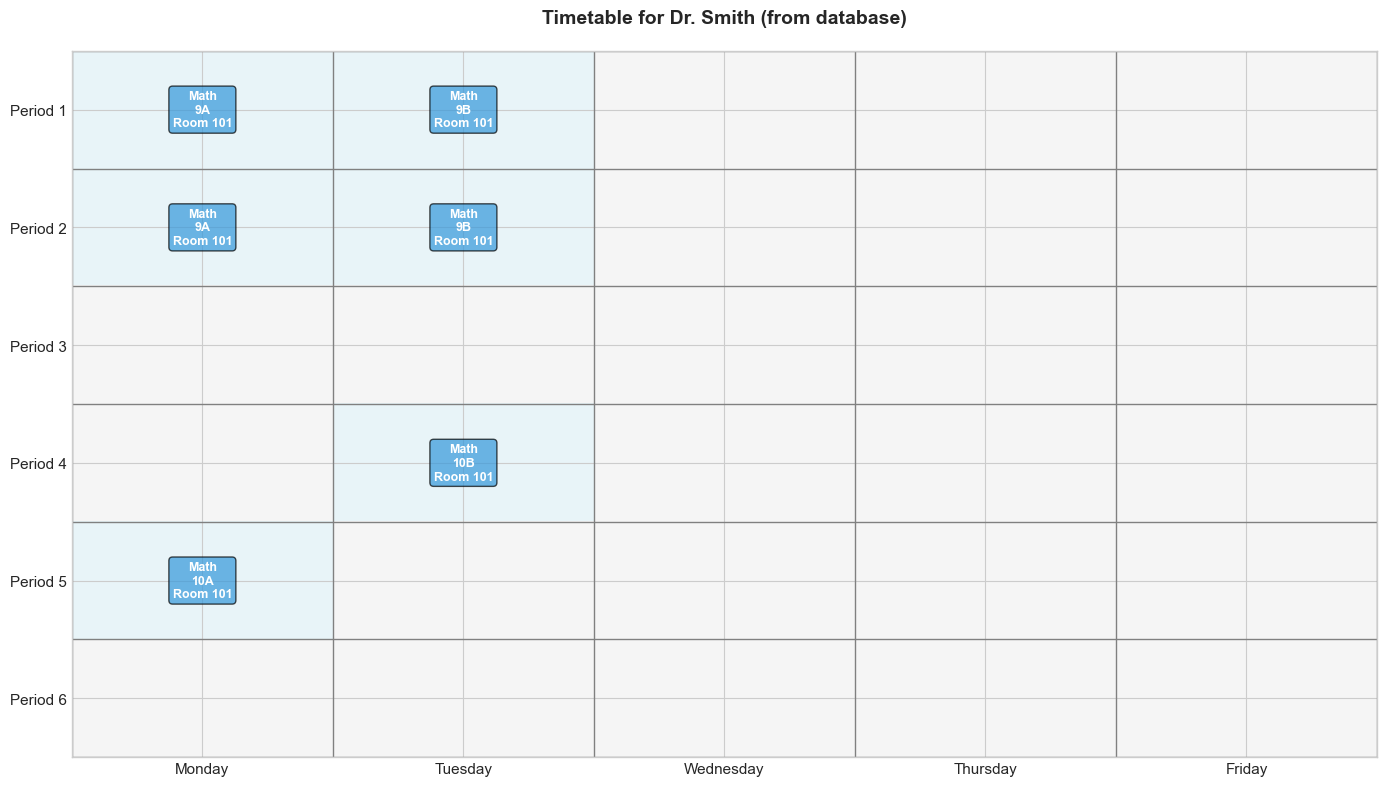

In [11]:
# Plot timetable for first teacher
teacher = session.query(Teacher).first()
grid = create_teacher_timetable_from_db(session, teacher.id)
fig = plot_timetable(grid, f"Timetable for {teacher.name} (from database)")
plt.show()

## 11. Key Insights

### What We Learned

1. **`from_model(session)` vs `from_data(list)`**:
   - `from_data()`: Pass Python lists directly
   - `from_model()`: LumiX queries the database via SQLAlchemy session

2. **ORM Benefits**:
   - Type-safe database operations
   - IDE autocomplete for model attributes
   - No manual SQL queries
   - Easy to persist solutions back to database

3. **Performance Tip**: Use cached checkers (like `create_cached_fits_checker()`) to avoid repeated database queries during model building.

4. **Solution Persistence**: Store results in a separate table (`ScheduleAssignment`) for easy retrieval and analysis.

### Pattern: ORM Integration

```python
# Define ORM model
class MyEntity(Base):
    __tablename__ = 'my_entities'
    id = Column(Integer, primary_key=True)
    name = Column(String)

# Create session
session = SessionLocal()

# Use from_model()
variable = (
    LXVariable[MyEntity, int]("var")
    .indexed_by(LXIndexDimension(MyEntity, lambda e: e.id).from_model(session))
)
```

## 12. Extensions & Exercises

1. **Add relationships**: Define SQLAlchemy relationships between models
2. **Query optimization**: Use `joinedload()` for eager loading
3. **Persistent database**: Connect to PostgreSQL or MySQL
4. **API integration**: Expose schedule via FastAPI
5. **Version history**: Track schedule changes over time

**Next notebook**: We'll add teacher preferences using goal programming.

In [ ]:
# Cleanup
session.close()
print("Session closed.")